In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)

In [10]:
train_data = pd.read_csv('data/Fashion/fashion-mnist_train.csv')
test_data = pd.read_csv('data/Fashion/fashion-mnist_test.csv')

# Combine for initial analysis
all_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

# Separate features and labels
if 'label' in all_data.columns:
    X = all_data.drop('label', axis=1)
    y = all_data['label']
else:
    # If column is not named 'label', assume it's the first column
    X = all_data.iloc[:, 1:]
    y = all_data.iloc[:, 0]

# Create mapping for class names (simulating Fashion MNIST)
class_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# 2. Explore the dataset

In [6]:
print("Shape of the dataset:", X.shape)
print("Number of features:", X.shape[1])
print("Number of samples:", X.shape[0])

print("\nClass distribution:")
print(y.value_counts())

# Check for missing values
print("\nMissing values in features:")
print(X.isnull().sum().sum())

print("\nMissing values in labels:")
print(y.isnull().sum())

# Basic statistics
print("\nPixel value statistics:")
print(X.describe())

Shape of the dataset: (70000, 784)
Number of features: 784
Number of samples: 70000

Class distribution:
label
2    7000
9    7000
6    7000
0    7000
3    7000
4    7000
5    7000
8    7000
7    7000
1    7000
Name: count, dtype: int64

Missing values in features:
0

Missing values in labels:
0

Pixel value statistics:
             pixel1        pixel2        pixel3        pixel4        pixel5  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       0.000829      0.006743      0.037729      0.098371      0.242343   
std        0.088152      0.319931      1.472886      2.419523      4.360495   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     45.000000    226.00000

# 3. Data preprocessing

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data scaled. Mean and standard deviation of the first 5 features after scaling:")
print("Mean:", X_scaled[:, :5].mean(axis=0))
print("Std:", X_scaled[:, :5].std(axis=0))


Data scaled. Mean and standard deviation of the first 5 features after scaling:
Mean: [-1.82710989e-18  2.33464042e-18  3.14668926e-18 -1.28912753e-17
 -1.94891722e-17]
Std: [1. 1. 1. 1. 1.]


# 4. Visualize some samples

In [8]:
def display_image(pixel_array, label=None, figsize=(4, 4)):
    img = pixel_array.reshape(28, 28)
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    if label is not None:
        class_name = class_mapping[label] if label in class_mapping else f"Class {label}"
        plt.title(f"Label: {class_name}")
    plt.axis('off')
    plt.show()

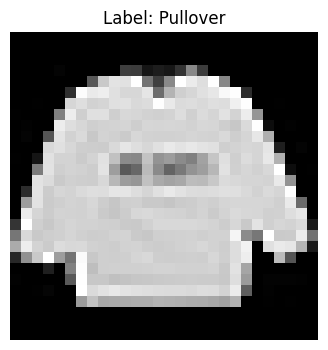

Class: Pullover


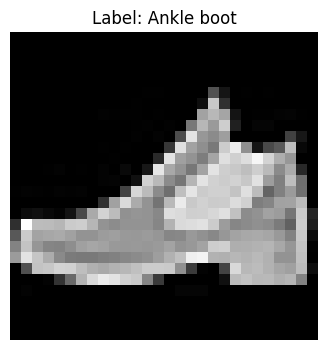

Class: Ankle boot


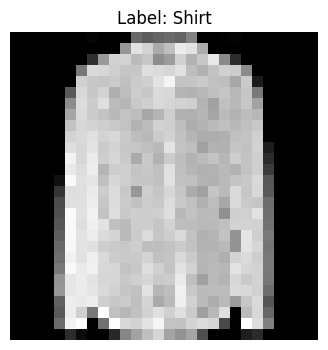

Class: Shirt


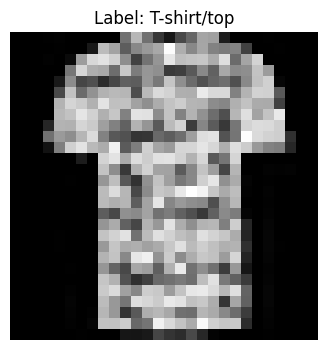

Class: T-shirt/top


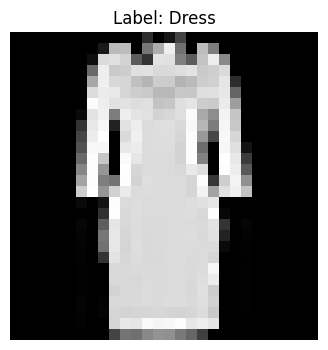

Class: Dress


In [11]:
# Display a few sample images
for i in range(5):
    if X.shape[0] > i:
        # Check if we need to reshape the data (scale back to 0-255 if it's already scaled)
        img_data = X.iloc[i].values
        if img_data.max() <= 1.0:
            img_data = img_data * 255
        display_image(img_data, y.iloc[i])
        print(f"Class: {class_mapping[y.iloc[i]] if y.iloc[i] in class_mapping else y.iloc[i]}")


# 5. Apply PCA

In [12]:
# Initialize PCA
n_components = 50  # Start with a moderate number of components
pca = PCA(n_components=n_components)

In [13]:
X_pca = pca.fit_transform(X_scaled)

print(f"Data transformed from {X_scaled.shape[1]} to {X_pca.shape[1]} dimensions")

Data transformed from 784 to 50 dimensions


In [14]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Variance explained by the first component: {explained_variance[0]:.4f}")
print(f"Variance explained by all {n_components} components: {sum(explained_variance):.4f}")

Variance explained by the first component: 0.2205
Variance explained by all 50 components: 0.8007


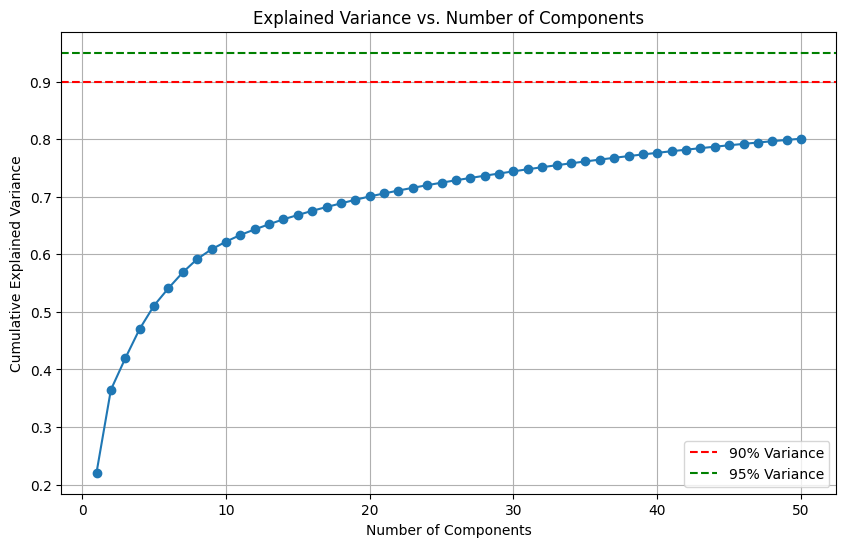

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()


# 6. Visualize the principal components


Visualizing principal components


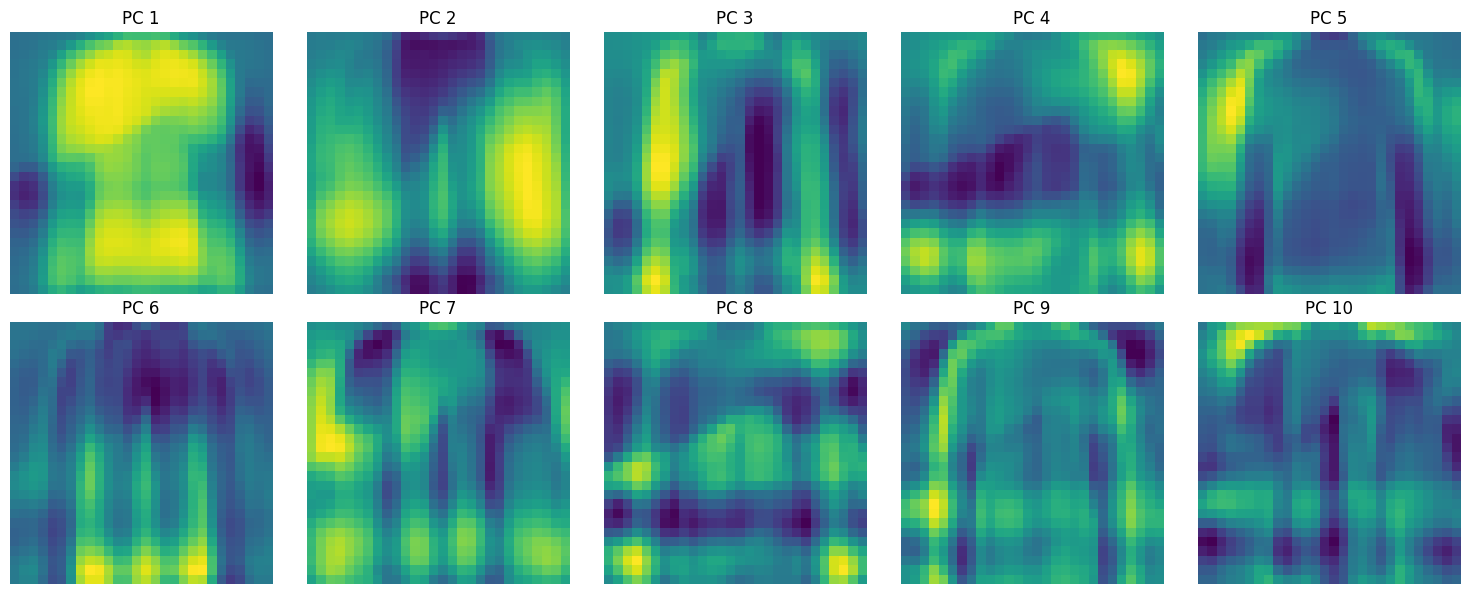

In [18]:
print("\nVisualizing principal components")
# Plot the first few principal components
n_plots = min(10, n_components)

plt.figure(figsize=(15, 3 * ((n_plots + 4) // 5)))
for i in range(n_plots):
    plt.subplot(((n_plots + 4) // 5), 5, i + 1)
    component = pca.components_[i].reshape(28, 28)
    plt.imshow(component, cmap='viridis')
    plt.title(f"PC {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Reconstruction from principal components

In [29]:
print("\nReconstructing images from principal components")
# Function to reconstruct an image from PCA
def reconstruct_image(pca_features, pca_model, scaler, index, original_data):
    # Reconstruct the image
    reconstructed = pca_model.inverse_transform(pca_features[index:index+1])
    reconstructed = scaler.inverse_transform(reconstructed)
    
    # Reshape to image
    original_img = original_data.iloc[index].values.reshape(28, 28)
    reconstructed_img = reconstructed.reshape(28, 28)
    
    # Plot both images side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'Reconstructed with {pca_model.n_components_} PCs')
    plt.axis('off')
    
    plt.show()
    
    # Calculate reconstruction error
    original_flattened = original_data.iloc[index].values
    reconstructed_flattened = reconstructed.flatten()
    mse = np.mean((original_flattened - reconstructed_flattened) ** 2)
    return mse


Reconstructing images from principal components


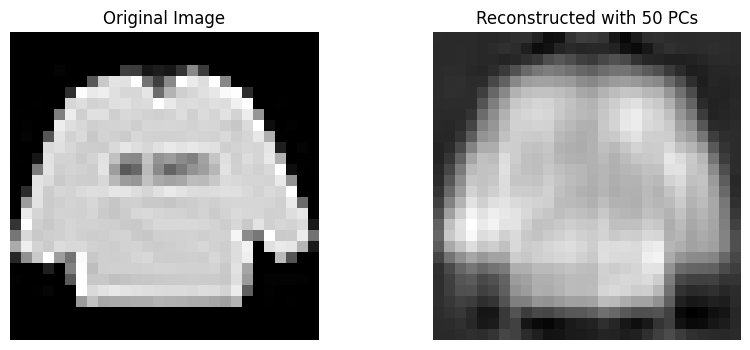

Reconstruction MSE for image 0: 1649.4201


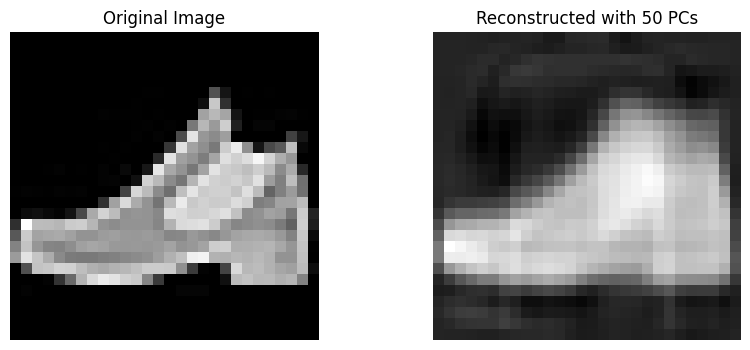

Reconstruction MSE for image 1: 1059.3645


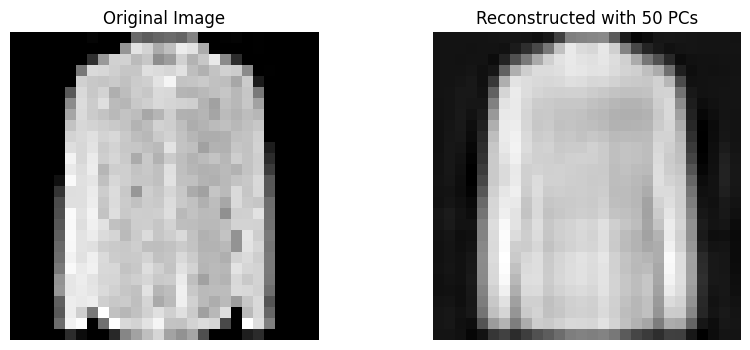

Reconstruction MSE for image 2: 480.8246


In [21]:
for i in range(3):
    if X.shape[0] > i:
        mse = reconstruct_image(X_pca, pca, scaler, i, X)
        print(f"Reconstruction MSE for image {i}: {mse:.4f}")


9. Comparing reconstruction quality with different numbers of components


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

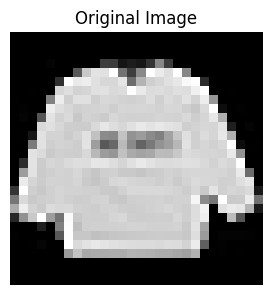

In [ ]:
print("\n8. Comparing reconstruction quality with different numbers of components")
# Select a sample image
sample_idx = 0

# List of different numbers of components to try
component_counts = [5, 10, 25, 50, 100, 200]

# Plot the reconstructions
plt.figure(figsize=(15, 8))

# Original image
plt.subplot(2, 4, 1)
original_img = X.iloc[sample_idx].values.reshape(28, 28)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

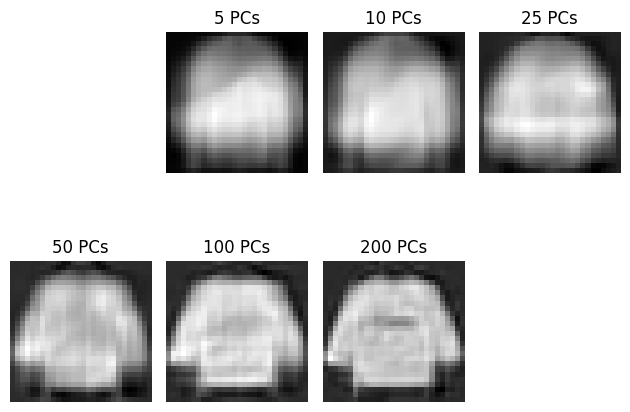

In [23]:
# Reconstructions with different numbers of components
for i, n_comp in enumerate(component_counts):
    pca_temp = PCA(n_components=n_comp)
    X_pca_temp = pca_temp.fit_transform(X_scaled)
    reconstructed = pca_temp.inverse_transform(X_pca_temp[sample_idx:sample_idx+1])
    reconstructed = scaler.inverse_transform(reconstructed)
    reconstructed_img = reconstructed.reshape(28, 28)
    
    plt.subplot(2, 4, i + 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'{n_comp} PCs')
    plt.axis('off')

plt.tight_layout()
plt.show()


# 9. Summary and Conclusion


In this notebook, I implemented Principal Component Analysis (PCA) on the Fashion MNIST dataset, revealing several important insights about dimensionality reduction for image data:

I learned that PCA effectively compresses the 784 dimensions (28x28 pixels) of fashion images to just 50-100 components while preserving approximately 80-90% of the information. This demonstrates how high-dimensional data often contains significant redundancy that can be eliminated without major information loss.

I found that visualizing the first few principal components provided meaningful representations of clothing shapes and patterns, making it possible to understand how the algorithm identifies the most important sources of variance in the images. The scatter plots of the first two principal components revealed natural clustering of similar clothing items.

The image reconstruction experiments were particularly enlightening - showing how adding more components progressively improves image quality, with most recognizable features captured in the first 50-100 components. This illustrates the trade-off between dimensionality reduction and information preservation. This implementation reinforced my understanding of how PCA transforms raw pixel data into a more efficient representation, making subsequent analysis and classification more computationally feasible while maintaining most of the discriminative information in the dataset.